# Imports

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
#
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor

# Import csv

In [2]:
data = pd.read_csv("../../tresboncoin/data/master_with_fuzzy_and_cleaning.csv")

# Exploring data

## Basic exploration

In [70]:
data.tail(12)

,category_db,bike_year,mileage,price,km/year
13366,scooter,2019,4600.0,4190.0,2300.000000
13367,dual sport,2019,8294.0,4200.0,4147.000000
13369,street,2019,8420.0,12190.0,4210.000000
13370,scooter,2020,4300.0,10990.0,4300.000000
13371,street,2005,68530.0,2499.0,4283.125000
13374,dual sport,2019,10694.0,3899.0,5347.000000
13375,dual sport,2016,28850.0,8352.0,5770.000000
13376,street,2016,64395.0,7290.0,12879.000000
13379,dual sport,2019,2097.0,4890.0,1048.500000
13380,street,2010,25000.0,4490.0,2272.727273


In [71]:
data["category_db"].value_counts()

street         7762
scooter        1593
dual sport      411
off-road        325
Name: category_db, dtype: int64

## Duplicates

In [7]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

141 duplicates were removed.


## Missing

In [8]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

brand_db       11.65987
model_db       11.65987
type_db        11.65987
category_db    11.65987
url             0.00000
uniq_id         0.00000
brand           0.00000
model           0.00000
bike_year       0.00000
mileage         0.00000
price           0.00000
dtype: float64

Input most frequent for <i style="color:orangered">brand</i>, <i style="color:orangered">model</i>, <i style="color:orangered">bike_type</i> features<br/>
Input mean for <i style="color:orangered">mileage</i>

## Distribution and outliers

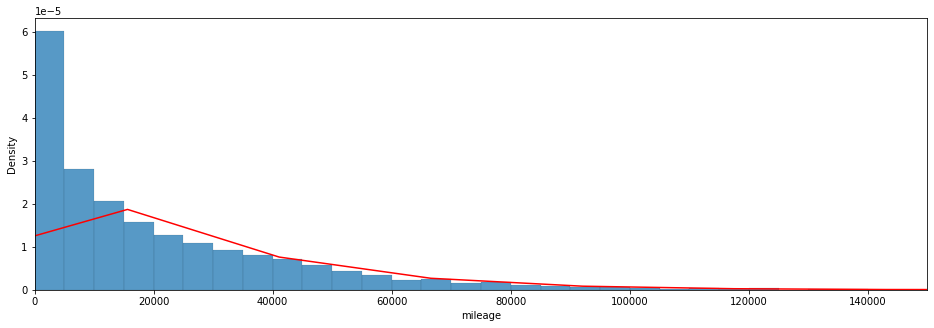

In [6]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(data["mileage"], palette='Blues', stat='density', bins=1000)
sns.kdeplot(data["mileage"], color='red')
plt.xlim(0, 150000);

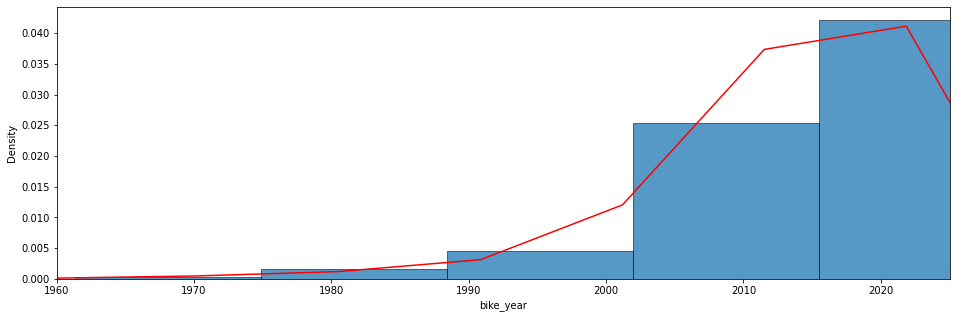

In [7]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(data["bike_year"], palette='Blues', stat='density', bins=150)
sns.kdeplot(data["bike_year"], color='red')
plt.xlim(1960, 2025);

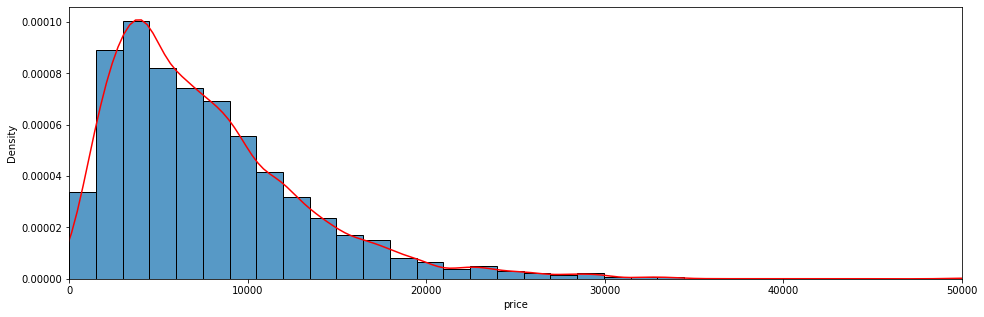

In [8]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(data["price"], palette='Blues', stat='density', bins=40)
sns.kdeplot(data["price"], color='red')
plt.xlim(0, 50000);

(0.0, 75000.0)

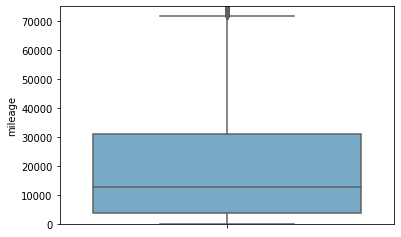

In [9]:
sns.boxplot(y=data["mileage"], palette="Blues");
plt.ylim(0, 75000)

(1960.0, 2022.0)

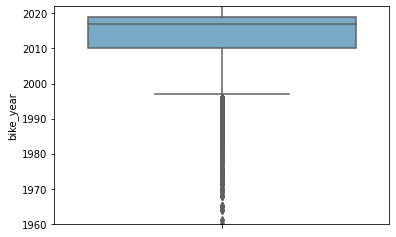

In [10]:
sns.boxplot(y=data["bike_year"], palette="Blues");
plt.ylim(1960, 2022)

(0.0, 50000.0)

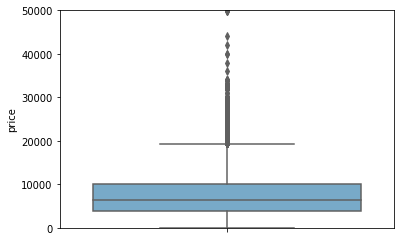

In [11]:
sns.boxplot(y=data["price"], palette="Blues");
plt.ylim(0, 50000)

# Cleaning

In [20]:
data = pd.read_csv("../../tresboncoin/data/master_with_fuzzy_and_cleaning.csv")

In [21]:
data = data[~data["brand_db"].isnull()]
data = data[~data["model_db"].isnull()]
data = data[~data["type_db"].isnull()]
data = data[~data["category_db"].isnull()]
data = data[(data["bike_year"]>=1970) & (data["bike_year"]<=2022)]
data = data[(data["mileage"]>=1000) & (data["mileage"]<=80000)]
data = data[(data["price"]>=1000) & (data["price"]<30000)]

In [22]:
def km_per_year(km, bike_year):
    if (datetime.now().year - bike_year) == 0:
        return km
    return km / (datetime.now().year - bike_year)

In [23]:
data.drop(['url', 'uniq_id', 'model_db', "type_db", 'brand', "model", "brand_db"], axis=1, inplace=True)
data['km/year'] = data.apply(lambda x: km_per_year(x['mileage'], x['bike_year']), axis=1)


# Preparing model inputs

In [46]:
X = data.drop(["price"], axis=1)
y = data["price"]

# Pipelines

In [82]:
pipe_multiclass = Pipeline([
    ('encoder', OneHotEncoder(sparse=False))
])

In [83]:
list(X.columns)

['category_db', 'bike_year', 'mileage', 'km/year']

In [84]:
# applying encoder
encoder = ColumnTransformer([
    ('textual', pipe_multiclass, ["category_db"])
], remainder='passthrough')

In [85]:
# full preprocessor pipeline
preprocessor = Pipeline([("encoder", encoder),
                         ('scaler', MinMaxScaler())])

In [86]:
output_pipe_columns = ["category_db_dual sport", "category_db_off-road", "category_db_scooter", "category_db_street", 'bike_year', 'mileage', 'km/year']

In [105]:
X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X), columns=output_pipe_columns)
X_train_scaled.tail()

,category_db_dual sport,category_db_off-road,category_db_scooter,category_db_street,bike_year,mileage,km/year
10086,0.0,0.0,0.0,1.0,0.901961,0.802468,0.260985
10087,1.0,0.0,0.0,0.0,0.960784,0.013886,0.020604
10088,0.0,0.0,0.0,1.0,0.784314,0.303797,0.045478
10089,1.0,0.0,0.0,0.0,0.960784,0.021620,0.026811
10090,1.0,0.0,0.0,0.0,0.960784,0.021620,0.026811


In [88]:
final_pipeline = Pipeline([
                          ("preprocessor", preprocessor),
                          ('model', ExtraTreesRegressor())
                         ])

# Baseline score

In [89]:
def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))
rmse = make_scorer(custom_rmse, greater_is_better=False)

In [90]:
baseline = cross_validate(final_pipeline,
                          X,
                          y,
                          scoring={"rmse": rmse, "r2": "r2"},
                          cv=10)
baseline_r2 = baseline['test_r2'].mean()
baseline_rmse = -baseline['test_rmse'].mean()

In [91]:
print(baseline_r2, baseline_rmse)

0.601707174191547 3109.3243454827525


# Optimized score

In [92]:
######################################################
# Random Forest Classifier model
######################################################
grid_ETR = {'model__max_depth': stats.randint(1, 1000),
            'model__min_samples_split': [2, 4, 6, 8, 10]
            #"preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
            }
params_ETR = {"random_grid_search": grid_ETR,
              "model": ExtraTreesRegressor()}
######################################################

In [93]:
model_optimized = RandomizedSearchCV(final_pipeline,
                                     grid_ETR,
                                     scoring="r2",
                                     n_iter=10,
                                     cv=10,
                                     n_jobs=-1,
                                     verbose=1)
model_optimized.fit(X, y)
optimized_r2 = model_optimized.best_score_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/victor/.pyenv/versions/3.9.1/envs/tresboncoin/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [94]:
print(optimized_r2)

0.6026549958305452


# Predict

street

scooter

dual sport

off-road

In [106]:
X_pred = pd.DataFrame({"category_db": ["scooter"],
                       "bike_year": [2014],
                       "mileage": [20000],
                       "km/year": [20000]
                       })

In [107]:
model_optimized.best_estimator_.predict(X_pred)

array([7385.45])

In [61]:
scaler = RobustScaler()

In [62]:
df_scaled = scaler.fit_transform(df)

# Training

In [63]:
def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))
#
rmse = make_scorer(custom_rmse, greater_is_better=False)

In [64]:
y_train.mean()

7866.19341894061

## Test Random forest regressor

In [65]:
model_RFR = RandomForestRegressor()

In [66]:
baseline_RFR = cross_validate(model_RFR,
                              df_scaled,
                              y_train,
                              #scoring=rmse,
                              cv=5)
baseline_RFR = -round(baseline_RFR["test_score"].mean(), 3)
baseline_RFR

-0.57

In [125]:
grid_RFR = {'n_estimators': stats.randint(1, 500),
            'max_depth': stats.randint(1, 500),
            "criterion": ["mse"]
            }

search_RFR = RandomizedSearchCV(model_RFR,
                                grid_RFR,
                                scoring=rmse,
                                n_iter=10,
                                cv=2,
                                n_jobs=-1,
                                verbose=True)

search_RFR.fit(df_scaled, y_train);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


In [126]:
search_RFR.best_params_

{'criterion': 'mse', 'max_depth': 344, 'n_estimators': 426}

In [127]:
search_RFR.best_estimator_ #RandomForestRegressor(max_depth=275, n_estimators=302)

RandomForestRegressor(max_depth=344, n_estimators=426)

In [128]:
tuned_RFR = cross_validate(search_RFR.best_estimator_,
                           df_scaled,
                           y_train,
                           scoring=rmse,
                           cv=5)
tuned_RFR = -round(tuned_RFR["test_score"].mean(), 3)
tuned_RFR

2612.349

## extra tree

In [73]:
from sklearn.ensemble import ExtraTreesRegressor
model_Ensemble_extraTREE = ExtraTreesRegressor()

In [74]:
baseline_Ensemble_extraTREE = cross_validate(model_Ensemble_extraTREE,
                                             df_scaled,
                                             y_train,
                                             scoring={"rmse":rmse, "r2": "r2"},
                                             cv=50);
pd.DataFrame({"rmse": [-baseline_Ensemble_extraTREE['test_rmse'].mean()], "r2": [baseline_Ensemble_extraTREE['test_r2'].mean()]})

,rmse,r2
0,2975.81776,0.611413


In [75]:
model_Ensemble_extraTREE = ExtraTreesRegressor()
model_Ensemble_extraTREE.fit(df_scaled, y_train)

ExtraTreesRegressor()

In [76]:
new_moto = pd.DataFrame({"bike_year":[2016],
                         "mileage":[20000],
                         "km/year":[20000],
                         "category_db_dual sport":[0],
                         "category_db_off-road":[0],
                         "category_db_scooter":[1],
                         "category_db_street":[0]
                        })
new_moto_scaled = scaler.transform(new_moto)

In [72]:
model_Ensemble_extraTREE.predict(new_moto_scaled)

array([7015.75666667])

In [252]:
import joblib
import os
from termcolor import colored
#
def save_model():
    """ Save the model into a .joblib format """
    joblib.dump(model_Ensemble_extraTREE, "model.joblib")
    print(colored("Trained model saved locally", "green"))

In [249]:
save_model()

Trained model saved locally


In [253]:
def get_model():
    return joblib.load(os.path.join(".", "model.joblib"))

In [254]:
loaded_model = get_model()

In [255]:
loaded_model.predict(new_moto_scaled)

array([6979.38])